This code is from the Github repository of Kevin Systrom at https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb. In this notebook, he essentially developed a bayesian estimate method for the basic reproductive number for COVID cases by day using a Poisson likelihood.

In [10]:
import pandas as pd
import numpy as np
import csv

from itertools import chain, compress

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

#from datetime import datetime, timedelta
#from time import strftime

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


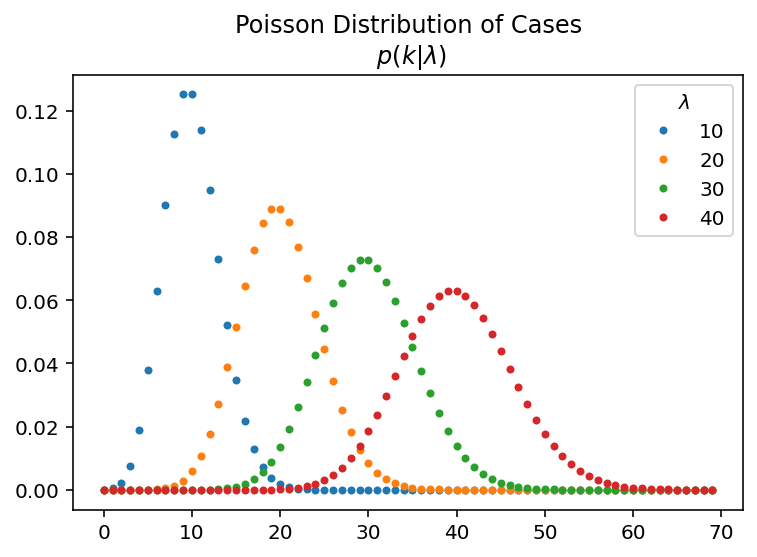

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

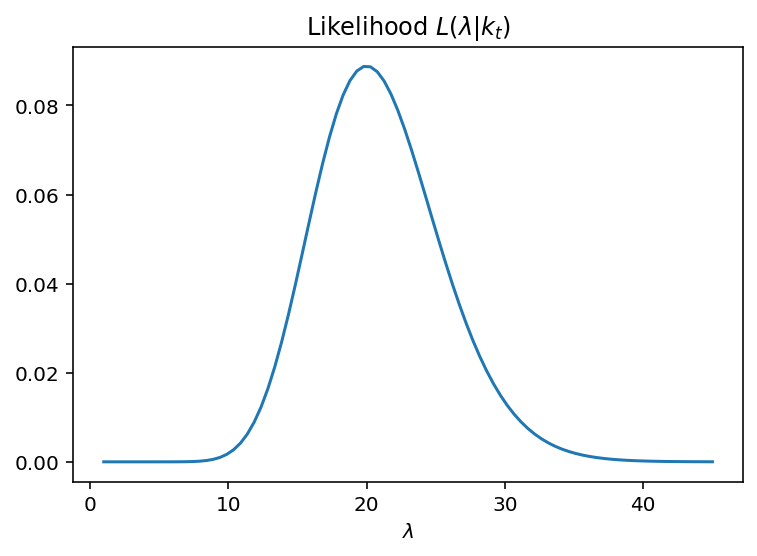

In [4]:
#Need to fix k and find the best likelihood for lambda
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$');

# Evaluate the likelihood function

The likelihood equation is 
\begin{equation*}
\mathcal{L}(R_t|k) = \frac{\lambda^ke^{-\lambda}}{k!}
\end{equation*}

where 

\begin{equation*}
\lambda = k_{t-1}e^{\gamma\left(R_t - 1\right)}
\end{equation*}

where $k_{t-1}$ is the number of cases for the previous day, $R_t$ is the estimated reproductive number at time $t$, and $\gamma$ is the reciprocal of the serial interval which is [about 4 days for COVID](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article). 

Now, let's run a toy scenario to evaluate the likelihood of $R_t$ over a sample of new case counts $k$.

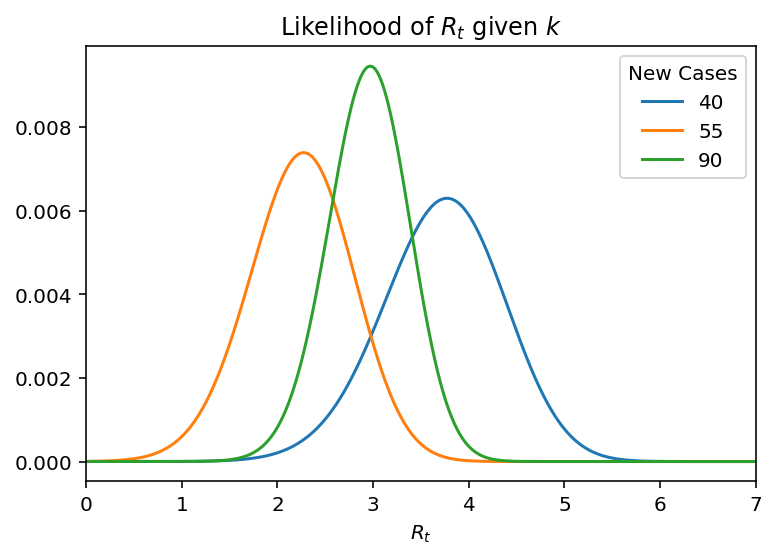

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

In [7]:
lam.shape

(1201, 3)

# Perform the Bayesian Update

To do that, you just simply multply the previous day's prior by the likelihood for the day you want to estimate.

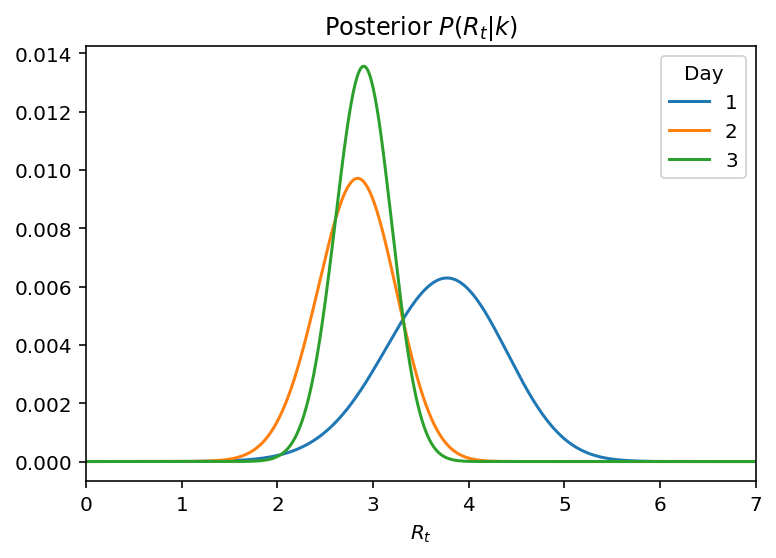

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Since we have the posterior distribution, we can now estimate the HDI.

In [7]:
most_likely_values = posteriors.idxmax(axis=0)

def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

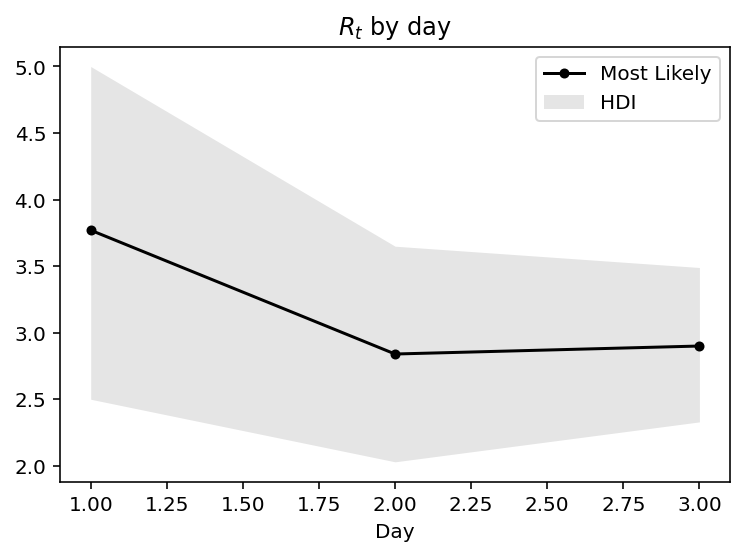

In [8]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low'],
                hdi['High'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

# Run the algorithm on Africa Data

## Setup

Load the data from the John Hopkins data repository. In order to work with this function, the Pandas data frame needs to be a time-series format.

In [24]:
def cleandata(df_raw):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='cases',var_name='date')
    df_cleaned.rename(columns={'Country/Region':'state'}, inplace=True)
    df_cleaned['date'] = pd.to_datetime(df_cleaned.date)
    df_cleaned=df_cleaned.set_index(['state','date'])
    df_cleaned.sort_index()
    df_cleaned = df_cleaned[['cases']]
    df_cleaned = pd.Series(df_cleaned['cases'].values, index=df_cleaned.index)
    return df_cleaned 

#url to raw data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

#list of African countries to evaluate
with open('africa-countries.csv', newline='') as f:
    reader = csv.reader(f)
    country_list = list(reader)
# country_list = pd.read_csv('africa-countries.csv')
# country_list = country_list.values.tolist()
country_list = list(chain.from_iterable(country_list))
#print(country_list)

#read in the raw data and filter for the African countries in the country_list variable
states = pd.read_csv(url)
states = cleandata(states)
states.rename(index={"Congo (Brazzaville)":"Congo"}, inplace=True)
states.rename(index={"Congo (Kinshasa)":"DR Congo"}, inplace=True)
states.rename(index={"Sao Tome and Principe":"Sao Tome & Principe"}, inplace=True)
states = states.loc[country_list]
states.head()


    



state         date      
Algeria       2020-01-22    0
Angola        2020-01-22    0
Benin         2020-01-22    0
Burkina Faso  2020-01-22    0
Cabo Verde    2020-01-22    0
dtype: int64

The following countries are not contailed in the dataset.

In [26]:
filter_list = states.index.get_level_values('state')
filter_list = filter_list.tolist()
list(set(country_list).difference(filter_list))

['Lesotho']

# Run a test case

I will start with the first country to get a feel for what the algorithm will do. The first plot is a simple time series plot of new cases per day with a smooted daily average.

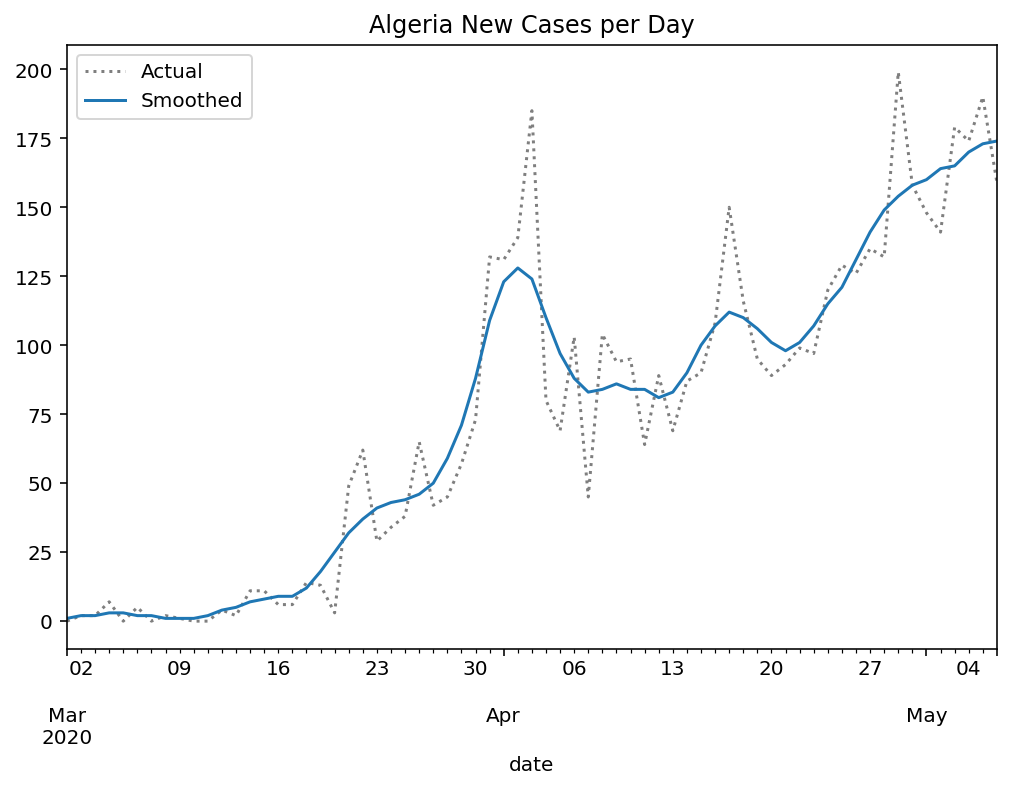

In [27]:
state_name = 'Algeria'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

## Run the algorithm

In [28]:
cases

date
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
              ... 
2020-05-02    4295
2020-05-03    4474
2020-05-04    4648
2020-05-05    4838
2020-05-06    4997
Name: Algeria cases, Length: 106, dtype: int64

This next set of code is what will compute the estimate of $R_t$.

In [29]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

## The result

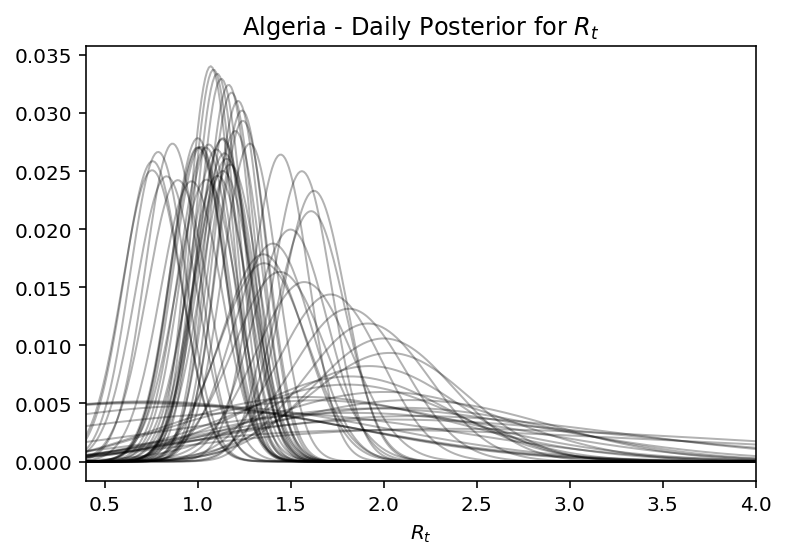

In [30]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

## Plotting in the time domain with credible intervals

In [31]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-05-02,1.17,0.93,1.42
2020-05-03,1.13,0.89,1.37
2020-05-04,1.10,0.87,1.34
2020-05-05,1.08,0.86,1.33
2020-05-06,1.07,0.83,1.29


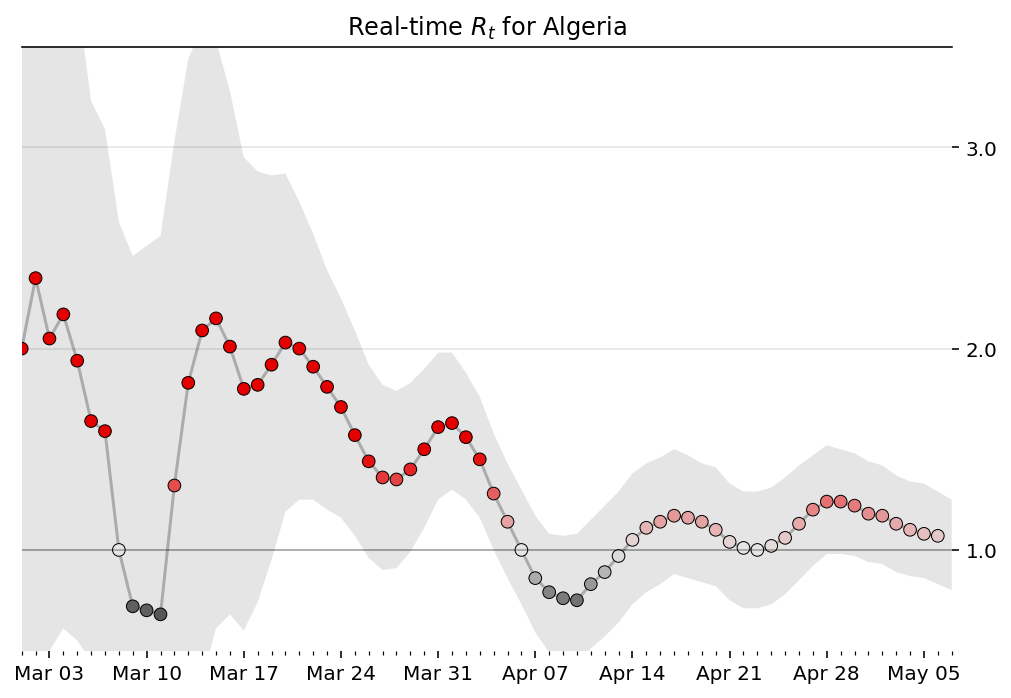

In [32]:

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Repeat for all Countries in the dataset

In [33]:
results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

for state_name, cases in states_to_process.groupby(level='state'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[state_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


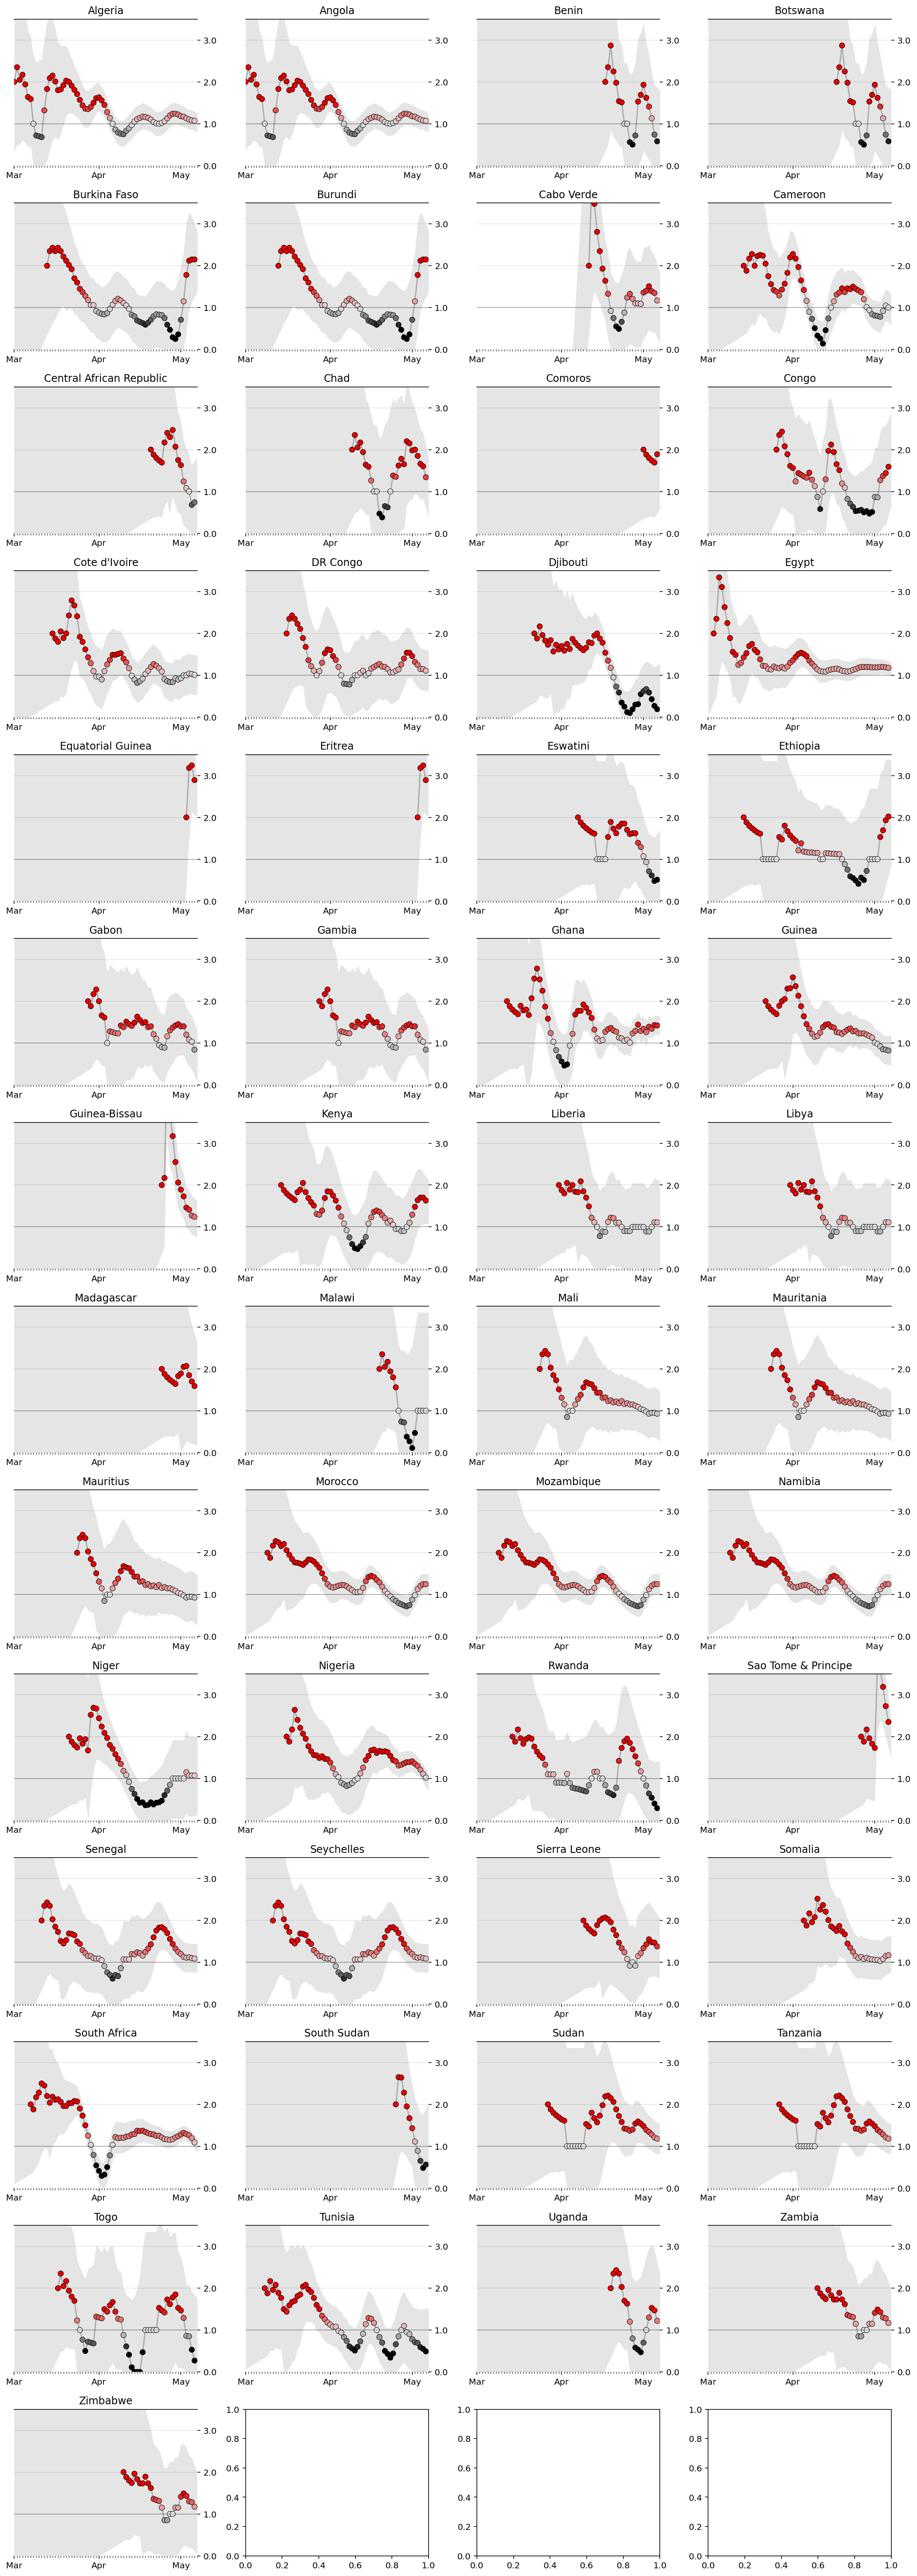

In [34]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

## Export

In [35]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

# Uncomment this line if you'd like to export
overall.to_csv('data/rt.csv')

## Standings

This code will create barplots with error bars and sort the bars from lowest to highest maximum likelihood of the $R_t$ value.

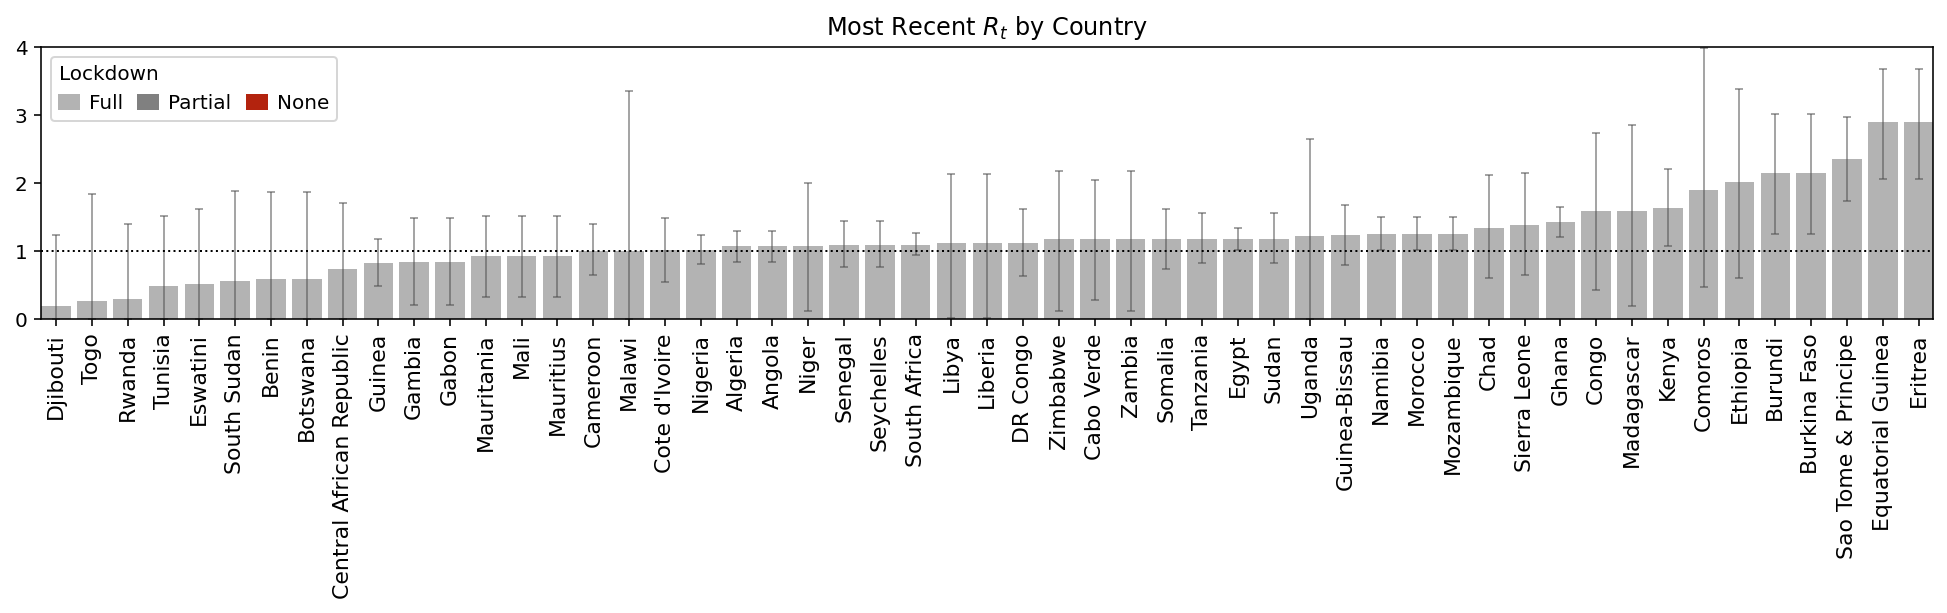

In [36]:
#Fill in these lists is you want to compare countries with various social distancing policies
no_lockdown = []
partial_lockdown = []

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
#     labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

The plot below depicts the high value of the confidence bands by country.

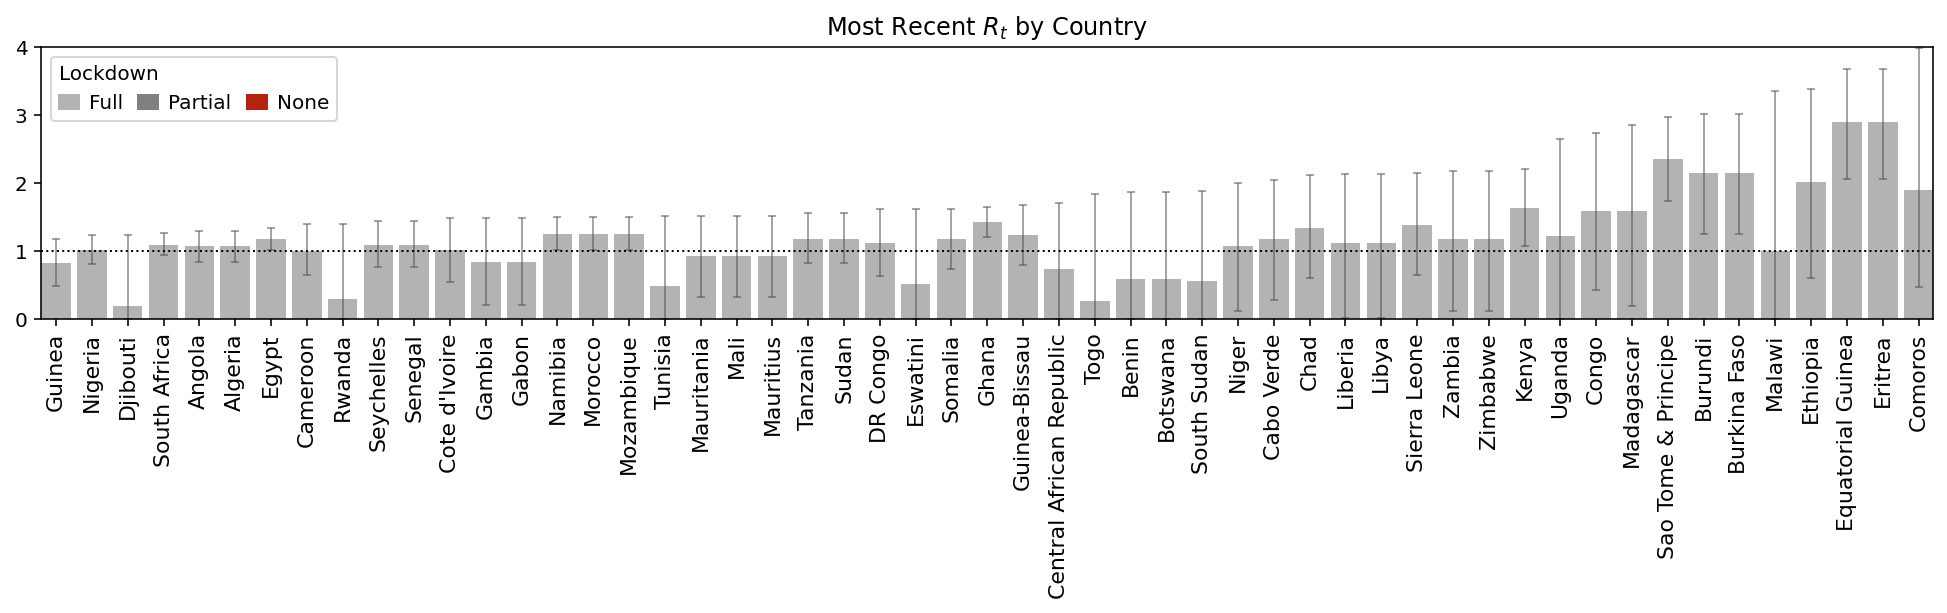

In [37]:
mr.sort_values('High', inplace=True)
plot_standings(mr);

# Likely under control countries

The following countries have high-end $R_t$ estimate of 1.3 or below which indicates they currently aren't experiencing a lot of widespread infection of multiple person from contact with one person.

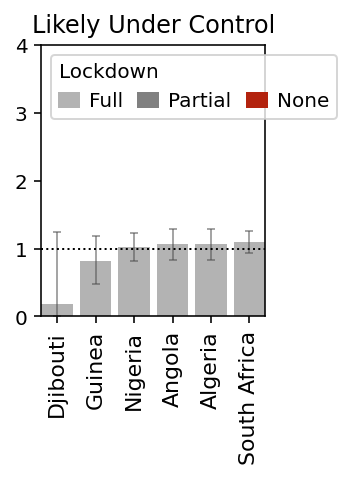

In [38]:
show = mr[mr.High.le(1.3)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

# Likely not under control countries

The following countries have low-end $R_t$ confidence estimate at least 1.05 which supports that these coutries have a severe number of persons infected by one person.

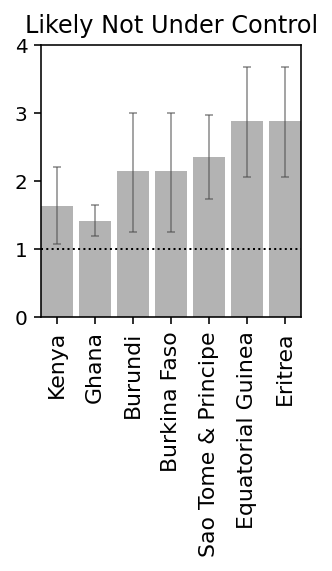

In [39]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()